# Project 2 – Section 2.2
## Up-and-out European Call option
This notebook implements the numerical tasks of Section 2.2:

1. Crude Monte Carlo estimator for the up-and-out European Call.
2. Importance sampling strategy via drift modification (r → r_tilde).
3. PDE-based optimal control importance sampling with barrier.
4. Repetition for a tighter barrier U = 170 with fine PDE discretization.

Parameter values (Section 2.2):
- T = 0.2
- K = 150
- sigma = 0.3
- U = 200 (later also U = 170)
- r = 0.1
- S0 = 100
- EM discretization: M = 1000

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from scipy.stats import norm

## Global parameters and payoff

Up-and-out European Call payoff:
$
\psi(\{S(t)\}_{t \in [0,T]}) =
e^{-rT} (S(T) - K)^+ \mathbf{1}_{\{\max_{t \in [0,T]} S(t) \le U\}}.
$

In [2]:
# Parameters for Section 2.2
T_22 = 0.2
K_22 = 150.0
sigma_22 = 0.3
r_22 = 0.1
S0_22 = 100.0
U_22 = 200.0

M_path = 1000
dt_path = T_22 / M_path
sqrt_dt_path = np.sqrt(dt_path)

def payoff_up_and_out_discounted(S_path, K, r, T, U):
    """
    Up-and-out European Call payoff with discrete monitoring:
    psi = e^{-rT} (S_T - K)^+ * 1_{max S_m <= U}.
    S_path: array of shape (M+1,) with S_0,...,S_M.
    """
    S_T = S_path[-1]
    max_S = np.max(S_path)
    if max_S <= U:
        return np.exp(-r * T) * max(S_T - K, 0.0)
    else:
        return 0.0


## Euler–Maruyama simulation for GBM paths
SDE:

$
dS(t) = r S(t)\,dt + \sigma S(t)\,dW(t),
$

discretized as:

$
S_{m+1} = S_m + r S_m \Delta t + \sigma S_m \Delta W_m,\quad
\Delta W_m \sim \mathcal{N}(0, \Delta t).
$

In [3]:
def simulate_gbm_em_paths(N, S0, r, sigma, T, M):
    """
    Simulate N GBM paths with EM.
    Returns an array of shape (N, M+1).
    """
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    S_paths = np.empty((N, M + 1))
    S_paths[:, 0] = S0
    
    for m in range(M):
        Z = np.random.randn(N)
        dW = sqrt_dt * Z
        S = S_paths[:, m]
        S_paths[:, m + 1] = S + r * S * dt + sigma * S * dW
    
    return S_paths

## 2.2.1 Crude Monte Carlo

- Simulate N paths of the GBM with EM and M=1000.
- Evaluate the up-and-out payoff on each path.
- Compute the crude Monte Carlo estimator and its standard deviation.

In [ ]:
def mc_up_and_out_crude(N, S0, r, sigma, T, K, U, M):
    """
    Crude MC estimator for the up-and-out European Call.
    
    Returns:
      estimate, standard deviation of the payoff sample.
    """
    S_paths = simulate_gbm_em_paths(N, S0, r, sigma, T, M)
    payoffs = np.empty(N)
    for i in range(N):
        payoffs[i] = payoff_up_and_out_discounted(S_paths[i, :], K, r, T, U)
    est = np.mean(payoffs)
    std = np.std(payoffs, ddof=1)
    return est, std

# Example: compute crude MC for a range of N
N_list_22 = [10, 100, 1000, 10_000, 100_000]
mc_results_22 = []
for N in N_list_22:
    est, std = mc_up_and_out_crude(
        N, S0_22, r_22, sigma_22, T_22, K_22, U_22, M_path
    )
    mc_results_22.append((N, est, std))

mc_results_22

[(10, 0.0, 0.0),
 (100, 0.0, 0.0),
 (1000, 0.01881101354709505, 0.3487690820582367),
 (10000, 0.013314709498035631, 0.4128233039068837),
 (100000, 0.009618042747349459, 0.31540854720218864)]

## 2.2.2 Importance Sampling via drift modification

We simulate the GBM under drift $\tilde{r}$, track the Brownian increments $\Delta W$,
and reweight with the pathwise Girsanov factor:

$
w = \exp\left(-\theta \tilde W_T + \frac{1}{2}\theta^2 T\right),
\qquad \theta = \frac{r - \tilde{r}}{\sigma}.
$

Estimator:
$
\hat{Z}_{\text{IS}} =
\frac{1}{N}\sum_{i=1}^N \psi(\text{path}^{(i)}) w^{(i)}.
$

In [5]:
def mc_up_and_out_IS_fixed_rtilde(
    N, S0, r, r_tilde, sigma, T, K, U, M
):
    """
    Importance sampling estimator for up-and-out call by changing drift r -> r_tilde.
    
    Args:
        N: number of paths
        S0, r, r_tilde, sigma, T, K, U, M: parameters
    
    Returns:
        estimate, std of weighted payoffs
    """
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    theta = (r - r_tilde) / sigma  # Brownian shift parameter
    payoffs_weighted = np.empty(N)
    
    for i in range(N):
        S = S0
        S_path = np.empty(M + 1)
        S_path[0] = S0
        
        W_tilde = 0.0
        
        for m in range(M):
            Z = np.random.randn()
            dW_tilde = sqrt_dt * Z
            W_tilde += dW_tilde
            
            S = S + r_tilde * S * dt + sigma * S * dW_tilde
            S_path[m + 1] = S
        
        payoff = payoff_up_and_out_discounted(S_path, K, r, T, U)
        weight = np.exp(-theta * W_tilde + 0.5 * theta**2 * T)
        payoffs_weighted[i] = payoff * weight
    
    est = np.mean(payoffs_weighted)
    std = np.std(payoffs_weighted, ddof=1)
    return est, std

# Example: test fixed r_tilde values
rtilde_candidates = [0.1, 0.3, 0.5, 0.8]
N_IS = 50_000

is_results_22_fixed = []
for rtilde in rtilde_candidates:
    est, std = mc_up_and_out_IS_fixed_rtilde(
        N_IS, S0_22, r_22, rtilde, sigma_22, T_22, K_22, U_22, M_path
    )
    is_results_22_fixed.append((rtilde, est, std))

is_results_22_fixed

[(0.1, 0.010581861400079046, 0.3398168789085459),
 (0.3, 0.06198206218970253, 1.4497696456021312),
 (0.5, 0.464426960378275, 7.152545173655223),
 (0.8, 6.728183448504611, 80.16844351667947)]

### Grid-based adaptive selection of $\tilde{r}$

For a given sample size N_base:
- Loop over $\tilde{r}$ in a grid.
- For each $\tilde{r}$, estimate the IS variance.
- Select the $\tilde{r}$ with minimal estimated variance.

Then, with this $\tilde{r}^*$, we can increase N until a desired CI half-width is achieved.

In [6]:
def grid_search_optimal_rtilde(
    r_grid, N_base, S0, r, sigma, T, K, U, M
):
    """
    Grid-based search for r_tilde that minimises empirical variance of the IS estimator.
    
    Returns:
        r_tilde_opt, results_list
    where results_list contains tuples (r_tilde, est, std).
    """
    results = []
    best_rtilde = None
    best_var = np.inf
    
    for rtilde in r_grid:
        est, std = mc_up_and_out_IS_fixed_rtilde(
            N_base, S0, r, rtilde, sigma, T, K, U, M
        )
        var = std**2
        results.append((rtilde, est, std))
        if var < best_var:
            best_var = var
            best_rtilde = rtilde
    
    return best_rtilde, results

# Example grid search
r_grid_example = np.linspace(0.1, 1.0, 10)
N_base_example = 20_000

rtilde_opt_22, grid_results_22 = grid_search_optimal_rtilde(
    r_grid_example, N_base_example,
    S0_22, r_22, sigma_22, T_22, K_22, U_22, M_path
)

rtilde_opt_22, grid_results_22[:5]

(0.1,
 [(0.1, 0.007321733741068663, 0.2507373648538431),
  (0.2, 0.02084219826729862, 0.68219583203798),
  (0.30000000000000004, 0.07437743602819598, 1.6348836442174082),
  (0.4, 0.2059112692731011, 4.132512785217016),
  (0.5, 0.49971442460336873, 7.979365744270329)])

In [ ]:
# Once rtilde_opt_22 is found, we can refine the estimate with a larger N.
N_IS_refined = 100_000 # ~36.7 seconds execution time for  N_IS_refined = 100_000 
est_IS_opt_22, std_IS_opt_22 = mc_up_and_out_IS_fixed_rtilde(
    N_IS_refined, S0_22, r_22, rtilde_opt_22, sigma_22, T_22, K_22, U_22, M_path
)
(est_IS_opt_22, std_IS_opt_22)

(0.007751976098656649, 0.27952456308301243)

## 2.2.3 PDE with barrier and optimal control $\zeta^*$
We solve the PDE

$\frac{\partial v}{\partial t} + rs \frac{dv}{ds} + \frac{1}{2}\sigma^2 s^2 \frac{\partial^2 v}{\partial s^2}$,

with:
- Final condition: $v(T, s) = (s - K)^+ e^{-rT}$.
- Spatial domain:
    - $S_\text{min}$ as in the Section 2.1 guideline: $S_\text{min} = S_0 \exp\{ (r- 0.5\sigma^2)T - 6 \sigma \sqrt{T} \}$,
    - $S_\text{max} = U$.
- Boundary conditions: $v(t, S_\text{min}) = 0, \quad v(t, S_\text{max}) = \varepsilon, \quad \varepsilon = 0.1$.

Again, we use implicit Euler in time and centered finite differences in space.



In [12]:
def pde_domain_parameters(S0, r, sigma, T, n_sigma=6.0):
    """
    Compute Smin according to the guideline:
    Smin = S0 * exp((r - 0.5 sigma^2)T - n_sigma * sigma sqrt(T)).
    Smax is set externally (e.g., barrier U).
    """
    mu = (r - 0.5 * sigma ** 2) * T
    S_min = S0 * np.exp(mu - n_sigma * sigma * np.sqrt(T))
    return S_min

def terminal_condition_v_up_and_out(T, s, r, K):
    """
    Terminal condition: v(T, s) = (s - K)^+ e^{-rT}.
    """
    return np.exp(-r * T) * np.maximum(s - K, 0.0)

In [8]:
def solve_pde_implicit_barrier(
    S0, r, sigma, T, K, U, eps_bc=0.1,
    P=200, M_tilde=200
):
    """
    Solve the backward Kolmogorov PDE with barrier boundary condition:
      v(t, Smin) = 0,
      v(t, Smax=U) = eps_bc.
    
    Returns:
        t_grid: shape (M_tilde+1,)
        s_grid: shape (P+1,)
        V: shape (M_tilde+1, P+1) with V[n, j] ≈ v(t_n, s_j).
    """
    S_min = pde_domain_parameters(S0, r, sigma, T)
    S_max = U
    
    # Spatial grid
    P = int(P)
    s_grid = np.linspace(S_min, S_max, P + 1)
    ds = s_grid[1] - s_grid[0]
    
    # Time grid
    M_tilde = int(M_tilde)
    t_grid = np.linspace(0.0, T, M_tilde + 1)
    dt = t_grid[1] - t_grid[0]
    
    # Initialize V at final time
    V = np.zeros((M_tilde + 1, P + 1))
    V[-1, :] = terminal_condition_v_up_and_out(T, s_grid, r, K)
    
    # Coefficient arrays
    a = np.zeros(P + 1)
    b = np.zeros(P + 1)
    c = np.zeros(P + 1)
    
    for j in range(1, P):
        s = s_grid[j]
        alpha = 0.5 * sigma**2 * s**2
        beta = r * s
        
        a[j] = dt * (alpha / ds**2 - beta / (2 * ds))
        b[j] = 1.0 - dt * (-2 * alpha / ds**2)
        c[j] = dt * (alpha / ds**2 + beta / (2 * ds))
    
    # Backward time-stepping
    for n in reversed(range(M_tilde)):
        rhs = V[n + 1, :].copy()
        t_n = t_grid[n]
        
        # Boundary conditions at time t_n
        rhs[0] = 0.0           # v(t, Smin) = 0
        rhs[-1] = eps_bc       # v(t, Smax=U) = eps_bc
        
        # Tridiagonal system for interior points
        lower = -a[1:P]
        diag = b[1:P]
        upper = -c[1:P]
        
        rhs_int = rhs[1:P].copy()
        rhs_int[0] -= lower[0] * rhs[0]
        rhs_int[-1] -= upper[-1] * rhs[P]
        
        # Thomas algorithm
        cp = np.zeros_like(upper)
        dp = np.zeros_like(rhs_int)
        
        cp[0] = upper[0] / diag[0]
        dp[0] = rhs_int[0] / diag[0]
        
        for j in range(1, P - 1):
            denom = diag[j] - lower[j] * cp[j - 1]
            cp[j] = upper[j] / denom
            dp[j] = (rhs_int[j] - lower[j] * dp[j - 1]) / denom
        
        v_int = np.zeros(P - 1)
        v_int[-1] = dp[-1]
        for j in reversed(range(P - 2)):
            v_int[j] = dp[j] - cp[j] * v_int[j + 1]
        
        V[n, 0] = rhs[0]
        V[n, P] = rhs[P]
        V[n, 1:P] = v_int
    
    return t_grid, s_grid, V

### Computing $\zeta^*(t,s)$ and interpolation

We compute:

$
\zeta^*(t,s) = \sigma s \frac{\partial}{\partial s} \log v(t,s),
$

with centered finite differences in $s$, boundary prolongation at $S_\text{min}$,
and zero control at t = T.

In [9]:
def compute_zeta_star(t_grid, s_grid, V, sigma):
    """
    Compute ζ*(t, s) on the grid from V(t, s).
    
    Returns:
        zeta: same shape as V.
    """
    M_tilde = len(t_grid) - 1
    P = len(s_grid) - 1
    ds = s_grid[1] - s_grid[0]
    
    zeta = np.zeros_like(V)
    eps = 1e-14
    
    for n in range(M_tilde):
        v = V[n, :]
        v_safe = np.clip(v, eps, None)
        log_v = np.log(v_safe)
        
        for j in range(1, P):
            dlogv_ds = (log_v[j + 1] - log_v[j - 1]) / (2.0 * ds)
            zeta[n, j] = sigma * s_grid[j] * dlogv_ds
        
        zeta[n, 0] = zeta[n, 1]      # prolongation at Smin
        zeta[n, P] = zeta[n, P - 1]  # copy at Smax
    
    # Zero control at final time
    zeta[-1, :] = 0.0
    return zeta

In [10]:
def interpolate_zeta(t, s, t_grid, s_grid, zeta_grid):
    """
    Bilinear interpolation for ζ(t,s) on (t_grid, s_grid).
    Outside the domain, ζ is extended constantly.
    """
    t_clamped = np.clip(t, t_grid[0], t_grid[-1])
    s_clamped = np.clip(s, s_grid[0], s_grid[-1])
    
    it = np.searchsorted(t_grid, t_clamped) - 1
    if it < 0:
        it = 0
    if it >= len(t_grid) - 1:
        it = len(t_grid) - 2
    
    js = np.searchsorted(s_grid, s_clamped) - 1
    if js < 0:
        js = 0
    if js >= len(s_grid) - 1:
        js = len(s_grid) - 2
    
    t0, t1 = t_grid[it], t_grid[it + 1]
    s0, s1 = s_grid[js], s_grid[js + 1]
    
    wt = 0.0 if t1 == t0 else (t_clamped - t0) / (t1 - t0)
    ws = 0.0 if s1 == s0 else (s_clamped - s0) / (s1 - s0)
    
    z00 = zeta_grid[it, js]
    z01 = zeta_grid[it, js + 1]
    z10 = zeta_grid[it + 1, js]
    z11 = zeta_grid[it + 1, js + 1]
    
    z0 = (1 - ws) * z00 + ws * z01
    z1 = (1 - ws) * z10 + ws * z11
    z = (1 - wt) * z0 + wt * z1
    return z

### Solving PDE and computing $\zeta^*$ for U = 200

Use a moderate grid, e.g. $P = 200$, $\tilde{M} = 200$, and then:
- plot $\zeta^*(t,s)$ on a restricted region for inspection,
- simulate controlled paths with this $\zeta^*$.

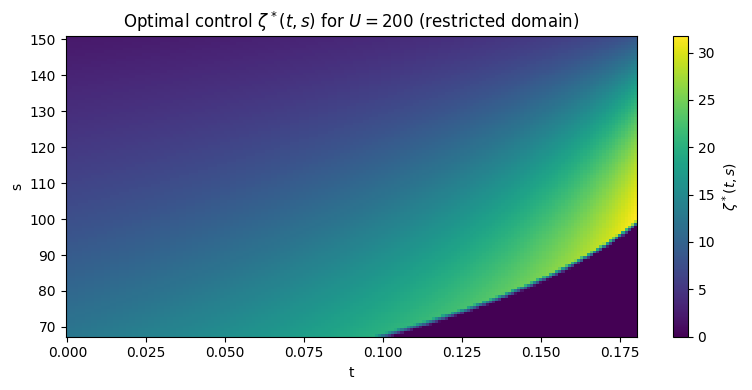

In [13]:
# Solve PDE on moderate grid for U = 200
t_grid_barrier, s_grid_barrier, V_barrier = solve_pde_implicit_barrier(
    S0=S0_22, r=r_22, sigma=sigma_22, T=T_22, K=K_22, U=U_22,
    eps_bc=0.1, P=200, M_tilde=200
)

zeta_barrier = compute_zeta_star(t_grid_barrier, s_grid_barrier, V_barrier, sigma=sigma_22)

# Restrict domain for plotting ζ*
mu_22 = (r_22 - 0.5 * sigma_22**2) * T_22
S1_22 = S0_22 * np.exp(mu_22 - 3 * sigma_22 * np.sqrt(T_22))
S2_22 = S0_22 * np.exp(mu_22 + 3 * sigma_22 * np.sqrt(T_22))

t_max_plot_22 = 0.18
it_max_22 = np.searchsorted(t_grid_barrier, t_max_plot_22)

s_mask_22 = (s_grid_barrier >= S1_22) & (s_grid_barrier <= S2_22)
s_grid_plot_22 = s_grid_barrier[s_mask_22]
t_grid_plot_22 = t_grid_barrier[:it_max_22 + 1]
zeta_plot_22 = zeta_barrier[:it_max_22 + 1][:, s_mask_22]

plt.figure(figsize=(8, 4))
T_mesh_22, S_mesh_22 = np.meshgrid(t_grid_plot_22, s_grid_plot_22, indexing='ij')
plt.pcolormesh(T_mesh_22, S_mesh_22, zeta_plot_22, shading='auto')
plt.colorbar(label=r'$\zeta^*(t,s)$')
plt.xlabel('t')
plt.ylabel('s')
plt.title(r'Optimal control $\zeta^*(t,s)$ for $U=200$ (restricted domain)')
plt.tight_layout()
plt.show()

### Controlled SDE simulation and optimal-control IS estimator

In [21]:
def simulate_controlled_up_and_out_IS(
    N, S0, r, sigma, T, K, U,
    t_grid, s_grid, zeta_grid,
    M_sde
):
    """
    Simulate controlled SDE paths and compute the IS estimator for the
    up-and-out call using the Girsanov weight induced by ζ*(t,s).
    
    Returns:
        estimate, std of weighted payoffs.
    """
    dt = T / M_sde
    sqrt_dt = np.sqrt(dt)
    
    payoffs_weighted = np.empty(N)
    
    for i in range(N):
        print(i+1, '/', N, end='\r')
        S = S0
        max_S = S0
        weight_log = 0.0
        
        for m in range(M_sde):
            t_m = m * dt
            dW = sqrt_dt * np.random.randn()
            
            z = interpolate_zeta(t_m, S, t_grid, s_grid, zeta_grid)
            
            drift = r * S + sigma * S * z
            S = S + drift * dt + sigma * S * dW
            if S > max_S:
                max_S = S
            
            weight_log += -0.5 * z**2 * dt - z * dW
        
        payoff = 0.0
        if max_S <= U:
            payoff = np.exp(-r * T) * max(S - K, 0.0)
        
        w = np.exp(weight_log)
        payoffs_weighted[i] = payoff * w
    
    est = np.mean(payoffs_weighted)
    std = np.std(payoffs_weighted, ddof=1)
    return est, std

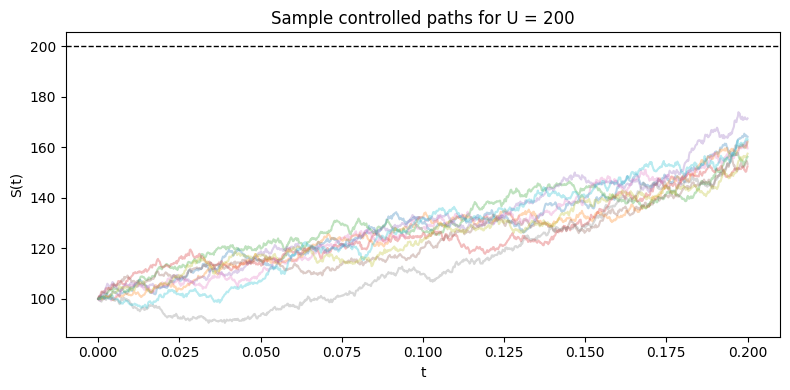

In [ ]:
# Example: simulate a small number of controlled paths for path visualization

N_paths_plot = 100
dt_vis = T_22 / M_path
sqrt_dt_vis = np.sqrt(dt_vis)

controlled_paths = np.empty((N_paths_plot, M_path + 1))
for i in range(N_paths_plot):
    S = S0_22
    controlled_paths[i, 0] = S
    for m in range(M_path):
        t_m = m * dt_vis
        dW = sqrt_dt_vis * np.random.randn()
        z = interpolate_zeta(t_m, S, t_grid_barrier, s_grid_barrier, zeta_barrier)
        drift = r_22 * S + sigma_22 * S * z
        S = S + drift * dt_vis + sigma_22 * S * dW
        controlled_paths[i, m + 1] = S

time_grid_vis = np.linspace(0.0, T_22, M_path + 1)
plt.figure(figsize=(8, 4))
for i in range(N_paths_plot):
    plt.plot(time_grid_vis, controlled_paths[i, :], alpha=0.3)
plt.axhline(U_22, color='k', linestyle='--', linewidth=1)
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Sample controlled paths for U = 200')
plt.tight_layout()
plt.show()

In [ ]:
# Example: controlled IS estimator with ζ* for U = 200
N_control_IS_22 = 50_000 # ~7m44s for 50,000 paths w result (est_opt_22, std_opt_22) = (0.009626652885851392, 0.002581027701967657)
est_opt_22, std_opt_22 = simulate_controlled_up_and_out_IS(
    N_control_IS_22,
    S0_22, r_22, sigma_22, T_22, K_22, U_22,
    t_grid_barrier, s_grid_barrier, zeta_barrier,
    M_sde=M_path
)

(est_opt_22, std_opt_22)

(0.009626652885851392, 0.002581027701967657)

## 2.2.4 Repeat with U = 170 and fine PDE discretization

- Barrier U = 170.
- PDE grid: P = 3000, M_tilde = 1500.
- Compute v(t,s), $\zeta^*(t,s)$.
- Optional: simulate controlled paths and compute IS estimator.

In [ ]:
# %%
U_22_tight = 170.0

# Solve PDE with fine discretization for U = 170
t_grid_barrier_tight, s_grid_barrier_tight, V_barrier_tight = solve_pde_implicit_barrier(
    S0=S0_22, r=r_22, sigma=sigma_22, T=T_22, K=K_22, U=U_22_tight,
    eps_bc=0.1, P=3000, M_tilde=1500
)

zeta_barrier_tight = compute_zeta_star(
    t_grid_barrier_tight, s_grid_barrier_tight, V_barrier_tight, sigma=sigma_22
)

# %%
# Example controlled IS estimator for U = 170 (can be expensive due to fine PDE grid)
N_control_IS_22_tight = 50_000
est_opt_22_tight, std_opt_22_tight = simulate_controlled_up_and_out_IS(
    N_control_IS_22_tight,
    S0_22, r_22, sigma_22, T_22, K_22, U_22_tight,
    t_grid_barrier_tight, s_grid_barrier_tight, zeta_barrier_tight,
    M_sde=M_path
)

(est_opt_22_tight, std_opt_22_tight) # = (0.007608730251829934, 0.004310090541748813) for N_control_IS_22_tight = 50_000

(0.007608730251829934, 0.004310090541748813)